# Exploring Topic and Word Relationships

Here we explore different ways that the the newstest 2015 dataset can be looked at.

In [1]:
import math

def read_file(file_path, max_amount=math.inf):
    """
    Reads a number of lines from file and return list of lines
    :param file_path:
    :param max_amount:
    :return: list[str]
    """
    line_list = []

    with open(file=file_path) as f:
        curr_idx = 0
        while curr_idx < max_amount:
            line_list.append(f.readline())
            curr_idx += 1

    return line_list

print("Loading file")
l_raw = read_file('./trg.shuf', 5000000)
print("Finished loading in file")

Loading file
Finished loading in file


In [28]:
import math
import pandas as pd
from collections import Counter
import operator
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
from gensim import corpora



def process_word(word, remove_stop=True, lemmatize_and_morph=True):
    """
    Returns process word
    :param word:
    :return: str word
    """
    # lower
    word = word.lower()
    
    # Remove symbols
    if len(word) < 3:
        return None
    
    # Get morph
    if lemmatize_and_morph is True:
        t_word = wn.morphy(word)
        if t_word is not None:
            word = t_word

        # Get lemma
        word = WordNetLemmatizer().lemmatize(word)
    
    # Remove stop
    if remove_stop is True and word in en_stop:
        return None
    return word


def preprocess_all_words(word_list):
    ret = []
    for line in word_list:
        temp = []
        for word in line:
            w = process_word(word, remove_stop=True, lemmatize_and_morph=False)
            if w is not None:
                temp.append(w)
        ret.append(temp)
    return ret


def process_bpe(line_list, seq="@@", rm_words=["\n"], lemmatize_and_morph=True):
    """
    Transforms line list form read_file to list[list[str=words]], and bpe words merged together
    :param line_list:
    :param seq:
    :param rm_words:
    :return: list[list[str=words]]
    """
    full_word_list = []
    for line in line_list:
        temp_words = line.split()
        full_words = []
        idx = 0
        while idx < len(temp_words):
            if temp_words[idx].endswith(seq):
                temp_str = ""
                while temp_words[idx].endswith(seq):
                    temp_str += temp_words[idx][:-(len(seq))]
                    idx += 1
                temp_str += temp_words[idx]
                if temp_str not in rm_words:
                    w = process_word(temp_str, lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                idx += 1
            else:
                if temp_words[idx] not in rm_words:
                    w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                idx += 1
        full_word_list.append(full_words)
    return full_word_list


def get_word_count(word_list):
    """
    Returns word count.
    :param word_list:
    :return: List[(str=word, int=count)]
    """
    word_count = {}
    for line in word_list:
        for word in line:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    return sorted(word_count.items(), key=operator.itemgetter(1))


def get_topics_lda(word_list, dictionary, num_topics=10):
    corpus = [dictionary.doc2bow(text) for text in word_list]
    print("Finished corpus")
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=4)
    print("Topics: ")
    for topic in topics:
        print(topic)

    return topics, ldamodel, corpus, dictionary

num_topics = 20

import random
l = random.sample(l_raw, 50000)

wl = process_bpe(line_list=l)
print("Vocab size train: " + str(len(get_word_count(word_list=wl))))

wl_full = process_bpe(line_list=l_raw, lemmatize_and_morph=False)
print("Vocab size full: " + str(len(get_word_count(word_list=wl_full))))

dictionary = corpora.Dictionary(wl_full)
print("Finished Dictionary")

t, ldamodel,_, dictionary = get_topics_lda(word_list=preprocess_all_words(wl), dictionary=dictionary, num_topics=num_topics)




[nltk_data] Downloading package wordnet to /home/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocab size train: 47708
Vocab size full: 1001125
Finished Dictionary
Finished corpus
Topics: 
(0, '0.004*"record" + 0.003*"hear" + 0.002*"map" + 0.002*"transfer"')
(1, '0.012*"european" + 0.008*"day" + 0.007*"right" + 0.006*"market"')
(2, '0.005*"phone" + 0.004*"article" + 0.004*"legal" + 0.003*"monday"')
(3, '0.018*"night" + 0.014*"2016" + 0.011*"sat" + 0.006*"currently"')
(4, '0.004*"far" + 0.004*"church" + 0.002*"role" + 0.002*"figure"')
(5, '0.009*"page" + 0.004*"generate" + 0.003*"new" + 0.003*"second"')
(6, '0.012*"post" + 0.006*"2010" + 0.006*"2007" + 0.005*"2006"')
(7, '0.004*"relate" + 0.003*"press" + 0.002*"element" + 0.002*"trip"')
(8, '0.004*"german" + 0.004*"language" + 0.003*"love" + 0.003*"french"')
(9, '0.008*"council" + 0.006*"2012" + 0.006*"price" + 0.005*"therefore"')
(10, '0.008*"also" + 0.008*"one" + 0.008*"say" + 0.007*"time"')
(11, '0.015*"http" + 0.004*"image" + 0.003*"tel" + 0.003*"economy"')
(12, '0.007*"hotel" + 0.006*"visit" + 0.006*"2013" + 0.005*"2014"')
(




# Visualization
Here we visualize with pyLDAvis in an interactive mode the LDA analysis.

In [21]:
import pyLDAvis.gensim
from gensim import corpora
dictionary = corpora.Dictionary(wl)
corpus = [dictionary.doc2bow(text) for text in wl]
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

# Vocab Splitting

Here we get the vocab for each topic.

In [29]:
def get_representatives_lda(word_list, lda_model, dictionary, num_topics=10):
    max_line = [[]] * num_topics
    max_class = [0] * num_topics 
    class_vocab = {i:{} for i in range(0, num_topics)}
    
    for line, idx in zip(word_list, range(len(word_list))):
        #print(line)
        new_doc_bow = dictionary.doc2bow(line)
        s = ldamodel.get_document_topics(new_doc_bow)
        s.sort(key=lambda x: x[1])
        t_max_class, t_max_perc = s[-1]
        
        for word in line:
            if word in class_vocab[t_max_class]:
                class_vocab[t_max_class][word] += 1
            else:
                class_vocab[t_max_class][word] = 1
        
        if max_class[t_max_class] < t_max_perc:
            max_class[t_max_class] = t_max_perc
            max_line[t_max_class] = line
        
        if idx % 100000 == 0:
            print("Representatives: " + str(idx))
        
    print("Finished representatives")
    return max_line, max_class, class_vocab


_, _, class_vocab = get_representatives_lda(wl_full, ldamodel, dictionary, num_topics=num_topics)

Representatives: 0
Representatives: 100000
Representatives: 200000
Representatives: 300000
Representatives: 400000
Representatives: 500000
Representatives: 600000
Representatives: 700000
Representatives: 800000
Representatives: 900000
Representatives: 1000000
Representatives: 1100000
Representatives: 1200000
Representatives: 1300000
Representatives: 1400000
Representatives: 1500000
Representatives: 1600000
Representatives: 1700000
Representatives: 1800000
Representatives: 1900000
Representatives: 2000000
Representatives: 2100000
Representatives: 2200000
Representatives: 2300000
Representatives: 2400000
Representatives: 2500000
Representatives: 2600000
Representatives: 2700000
Representatives: 2800000
Representatives: 2900000
Representatives: 3000000
Representatives: 3100000
Representatives: 3200000
Representatives: 3300000
Representatives: 3400000
Representatives: 3500000
Representatives: 3600000
Representatives: 3700000
Representatives: 3800000
Representatives: 3900000
Representatives

In [32]:


# max_l, max_c, class_vocab = get_representatives_lda(wl, ldamodel, dictionary)
"""
for idx in range(len(max_l)):
    print("\n")
    print("\n")
    print(max_c[idx])
    print(max_l[idx])
"""  

# get overlap
#num_topics = 20

import numpy as np


def get_overlap_matrix(class_vocab, num_topics):
    over_lap_matrix = np.zeros((num_topics, num_topics))
    over_lap_vocab = {}
    
    for c in range(0, num_topics):
        for c2 in range(0, num_topics):
            # Skip self
            if c2 >= c:
                continue
            # overlap
            words_in_c2_and_c1 = 0
            total_words_c2 = 0
            
            for word in class_vocab[c2]:
                if word not in over_lap_vocab:
                    over_lap_vocab[word] = np.zeros((num_topics, num_topics))
                
                total_words_c2 += 1 
                if word in class_vocab[c]:
                    words_in_c2_and_c1 += 1
                    over_lap_vocab[word][c, c2] = 1
            # Normalize        
            c_factor = len(class_vocab[c])/(len(class_vocab[c2]) + len(class_vocab[c]))
            c2_factor = len(class_vocab[c2])/(len(class_vocab[c2]) + len(class_vocab[c]))
            over_lap_matrix[c, c2] = (words_in_c2_and_c1/len(class_vocab[c2])) * c2_factor + (words_in_c2_and_c1/len(class_vocab[c])) * c_factor
    
    return over_lap_matrix, over_lap_vocab


over_lap_matrix, over_lap_vocab = get_overlap_matrix(class_vocab, num_topics)

over_lap_sum = 0
over_lap_count = 0
for c in range(0, num_topics):
    for c2 in range(0, num_topics):
        # Skip self
        if c2 >= c:
            continue
        over_lap_sum += over_lap_matrix[c, c2]
        over_lap_count += 1
        
over_lap_avg = over_lap_sum/over_lap_count

print("Overlap Matrix of Vocab")
print(pd.DataFrame(over_lap_matrix))
print("\n")

print("Average overall")
print(over_lap_avg)

print("\n")
print("Max")
print(np.max(over_lap_matrix))
      

Overlap Matrix of Vocab
          0         1         2         3         4         5         6   \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.320151  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.361944  0.298270  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.365961  0.287118  0.353892  0.000000  0.000000  0.000000  0.000000   
4   0.377716  0.341758  0.346009  0.354175  0.000000  0.000000  0.000000   
5   0.349275  0.284684  0.322226  0.320229  0.334651  0.000000  0.000000   
6   0.388647  0.331071  0.357600  0.374928  0.383218  0.340301  0.000000   
7   0.344817  0.300846  0.318238  0.314460  0.340512  0.332236  0.334143   
8   0.399386  0.328405  0.364263  0.370648  0.384095  0.347254  0.394343   
9   0.379233  0.382891  0.354255  0.364495  0.381506  0.329973  0.403175   
10  0.184421  0.366902  0.174013  0.161903  0.206407  0.172627  0.189058   
11  0.241602  0.230506  0.234845  0.234814  0.239068  0.221540  

# Results



## LDA

### 20 Topics, 50000 clustering, 5 million testing:

Without stop words, overall average 32.8% (max 42.5%).


### TODO: 5, 10 Topics

# Exploring vocab overlap

In [36]:
vocab_overlap_list = [(word, np.sum(over_lap_vocab[word])) for word in over_lap_vocab]
sort_vocab_overlap = sorted(vocab_overlap_list, key=lambda tup: tup[1])

print("Top 100 overlapping words: ")
print(sort_vocab_overlap[-100:-1])




Top 100 overlapping words: 
[('memo', 190.0), ('danny', 190.0), ('slots', 190.0), ('cottages', 190.0), ('lübeck', 190.0), ('firefox', 190.0), ('ready-made', 190.0), ('modest', 190.0), ('martha', 190.0), ('relate', 190.0), ('rubble', 190.0), ('olives', 190.0), ('whatsoever', 190.0), ('132', 190.0), ('salmonella', 190.0), ('giorgio', 190.0), ('camping', 190.0), ('2.7', 190.0), ('gallons', 190.0), ('leaked', 190.0), ('underwater', 190.0), ('wich', 190.0), ('5-10', 190.0), ('151', 190.0), ('169', 190.0), ('ecu', 190.0), ('dancer', 190.0), ('wholesale', 190.0), ('screens', 190.0), ('185', 190.0), ('hierarchy', 190.0), ('offline', 190.0), ('distortions', 190.0), ('revolt', 190.0), ('9.5', 190.0), ('puzzles', 190.0), ('geelong', 190.0), ('genuinely', 190.0), ('toyota', 190.0), ('ornamental', 190.0), ('aig', 190.0), ('harvest', 190.0), ('adjoining', 190.0), ('naval', 190.0), ('clusters', 190.0), ('hamburger', 190.0), ('147', 190.0), ('mafia', 190.0), ('n.j.', 190.0), ('christie', 190.0), ('hob

dict_items([(0.0, 692748), (1.0, 113524), (3.0, 49371), (6.0, 28685), (10.0, 19303), (15.0, 13753), (21.0, 10263), (28.0, 7957), (36.0, 6328), (45.0, 5313), (55.0, 4354), (66.0, 3923), (78.0, 3312), (91.0, 2996), (105.0, 2718), (120.0, 2545), (136.0, 2508), (153.0, 2538), (171.0, 2819), (190.0, 9841)])
984799


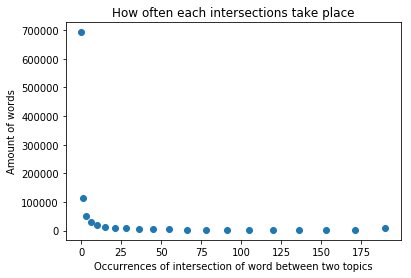

In [37]:
over_lap_distribution = {}
for word, count in sort_vocab_overlap:
    if count in over_lap_distribution:
        over_lap_distribution[count] += 1
    else:
        over_lap_distribution[count] = 1

over_lap_distribution = over_lap_distribution.items()
print(over_lap_distribution)
print(sum([v[1] for v in over_lap_distribution]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*over_lap_distribution))
plt.title("How often each intersections take place")
plt.xlabel("Occurrences of intersection of word between two topics")
plt.ylabel("Amount of words")
plt.show()

In [55]:
print(over_lap_vocab['makarov'])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.